# My Tokenizer

In [80]:
import cProfile
import time
from collections import Counter
import csv


import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# set up tqdm
try:
    if 'ZMQInteractiveShell' == get_ipython().__class__.__name__:
        from tqdm.notebook import tqdm
    else:
        from tqdm import tqdm
except NameError:
    from tqdm import tqdm

# config
MAX_VOCAB_SIZE: int = 50_000  # maximum size of vocab
MAX_TOKEN_LEN: int = 40  # maximum length of token
RANDOM_SEED = 42

# don't change these
MAX_ENTROPY = round(float(np.log2(MAX_VOCAB_SIZE)), 1)


## Load dataset

In [2]:
ds_name, data_dir, split = ("graelo/wikipedia", "20230901.en", "train")
#ds_name, data_dir, split = ("wikitext", "wikitext-2-raw-v1", "train")

print(f"Loading dataset...", flush=True)
t0 = time.time()
ds = load_dataset(ds_name, data_dir, split=split)
print(f"Loaded dataset in {time.time() - t0:.1f} seconds", flush=True)

Loading dataset...
Loaded dataset in 4.3 seconds


## Build Vocabulary

In [3]:
# standard byte ranges
ASCII_PUNCTUATION = [bytes([i]) for i in range(32,48)] + [bytes([i]) for i in range(58,65)] + [bytes([i]) for i in range(91,97)] + [bytes([i]) for i in range(123,127)]
ASCII_DIGITS = [bytes([i]) for i in range(48,58)]
ASCII_LOWERCASE = [bytes([i]) for i in range(97,123)]
ASCII_UPPERCASE = [bytes([i]) for i in range(65,91)]
ASCII_CONTROL = [bytes([i]) for i in range(0,32)]
NON_ASCII = [bytes([i]) for i in range(127,256)]

In [225]:
class Vocabulary(dict):

    def __init__(self, 
                 *args, 
                 no_merge_on_right=ASCII_PUNCTUATION + ASCII_CONTROL + ASCII_DIGITS,
                 no_merge_on_left=ASCII_CONTROL + ASCII_DIGITS,
                 truncate_freq_lower_bound=2, 
                 max_size=MAX_VOCAB_SIZE,
                 max_token_len=MAX_TOKEN_LEN,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.no_merge_on_right = no_merge_on_right
        self.no_merge_on_left = no_merge_on_left
        self.truncate_freq_lower_bound = truncate_freq_lower_bound
        self.max_size = max_size
        self.max_token_len = max_token_len

        # initialize with all bytes
        self.update({bytes([i]): .1 for i in range(256)})

    def mean(self):
        return np.mean(list(self.values()))

    def std(self):
        return np.std(list(self.values()))

    def sum(self):
        return sum(self.values())
    
    def entropy(self, precision=1):
        #return round(entropy(self.values()), precision)
        s = self.sum()
        if s <= 0:
            return 0
        p = np.array([v/s for v in self.values() if v > 0])
        with np.errstate(invalid='ignore'):
            h = np.nan_to_num((-p * np.log2(p))).sum()
        return round(h, precision)

    def most_common(self, n=None, reverse=False):
        if n is None:
            n = len(self) + 1
        return sorted(self.items(), key=lambda x: x[1], reverse=not reverse)[:n]

    def sorted_values(self, reverse=False):
        return sorted(list(self.values()), reverse=reverse)

    def prune_rare_tokens(self, freq_lower_bound=None, max_size=None):
        assert len(self) > 256, f"Vocabulary has {len(self)} tokens and cannot be truncated"

        if freq_lower_bound is None:
            freq_lower_bound = self.truncate_freq_lower_bound

        if max_size is None:
            max_size = self.max_size
        
        n_kept_tokens = len([t for t in self.keys() if len(t) == 1])
        for t, f in self.most_common():
            if len(t) == 1:
                continue
            elif (f < freq_lower_bound) or (n_kept_tokens >= max_size):
                del self[t]
            else:
                n_kept_tokens += 1

        #assert len(self) > 256, f"Vocabulary truncated down to individual bytes only, trying lowering `freq_lower_bound` or increasing `max_size`"
        assert len(self) <= max_size, f"Vocabulary failed to truncate down to `max_size`={max_size}"
    
    def find_next_token(self, text, threshold=None):
        if threshold is None:
            threshold = self.mean()

        prev_token = None
        prev_freq = None
        for L in range(1, self.max_token_len + 1):
            token = text[:L]
            if token in self.no_merge_on_left:
                return token
            if (len(token) > 1) and token[-1:] in self.no_merge_on_right:
                return prev_token
            if token[-1:] in self.no_merge_on_left:
                break
            if (token in self):
                prev_token = token
                prev_freq = self[token]
            else:
                break

        if (prev_token is None) or (prev_freq > threshold):
            return token
        else:
            return prev_token

    def __repr__(self):
        mc = self.most_common()
        return f"Vocabulary({{{mc[0][0]}: {mc[0][1]}, ..., {mc[-1][0]}: {mc[-1][1]}}})"
        return f"Vocabulary({super().__repr__()})"

    @classmethod
    def create(cls, 
               dataset, 
               no_merge_on_right=ASCII_PUNCTUATION + ASCII_CONTROL + ASCII_DIGITS,
               no_merge_on_left=ASCII_CONTROL + ASCII_DIGITS,
               truncate_freq_lower_bound=2, 
               max_size=MAX_VOCAB_SIZE,
               max_token_len=MAX_TOKEN_LEN,
               ):

        # load the dataset to find tokens in 
        dl = dataset.to_iterable_dataset().shuffle(seed=RANDOM_SEED, buffer_size=10_000)

        # initialize the new vocabulary
        vocab = cls(no_merge_on_right=no_merge_on_right,
                    no_merge_on_left=no_merge_on_left,
                    truncate_freq_lower_bound=truncate_freq_lower_bound, 
                    max_size=max_size,
                    max_token_len=max_token_len)

        # initialize progress log
        time_stamps = [time.time()]
        token_freq_log = [vocab.sorted_values()]

        # find tokens in the dataset
        with tqdm(desc="tokens found", total=vocab.max_size, initial=len(vocab), unit="token", leave=True) as tokens_pb:
            with tqdm(desc=f"current entropy [ sum(-p * log2(p)) ]", total=MAX_ENTROPY, initial=vocab.entropy(), unit="bit", leave=True) as entropy_pb:
                with tqdm(desc=f"best poss entropy [ log2(len(vocab)) ]", total=MAX_ENTROPY, initial=np.log2(len(vocab)), unit="bit", leave=True) as best_entropy_pb:
                    with tqdm(desc="dataset examples", total=len(dataset), unit="example", leave=True) as examples_pb:
                        for i, example in enumerate(dl):
                            examples_pb.update(1)
                            text = bytes(example['text'], 'utf-8')

                            # find tokens in this example
                            while text:
                                t = vocab.find_next_token(text[:vocab.max_token_len])
                                text = text[len(t):]
                                vocab[t] = vocab.get(t, 0) + 1

                            # every 5 examples, prune rare tokens and update progress bars
                            if i % 5 == 0:
                                # prune any token only seen once    
                                vocab.prune_rare_tokens(freq_lower_bound=2)

                                # update progress bars
                                tokens_pb.n = len(vocab)
                                tokens_pb.refresh()
                                entropy_pb.n = vocab.entropy()
                                entropy_pb.refresh()
                                best_entropy_pb.n = round(np.log2(len(vocab)), 1)
                                best_entropy_pb.refresh()

                                #log progress
                                time_stamps.append(time.time())
                                token_freq_log.append(vocab.sorted_values())
                            
                                # are we there yet?
                                if len(vocab) == vocab.max_size:
                                    break
                                if min(vocab.values()) > 10:
                                    # FIXME: some single-byte tokens never occur
                                    # we've seen the rarest token multiple times 
                                    # since we last found a new token. Time to give up.
                                    break

        return vocab, time_stamps, token_freq_log


In [12]:
#cProfile.run('vocab, time_stamps, token_freq_log = Vocabulary.create()')
vocab, time_stamps, token_freq_log = Vocabulary.create(ds, no_merge_on_right=ASCII_PUNCTUATION) 

dataset examples:   0%|          | 0/6705754 [00:00<?, ?example/s]

tokens found:   1%|          | 256/50000 [00:00<?, ?token/s]

curr entropy [ sum(-p*log2(p))  ]:   0%|          | 0/15.6 [00:00<?, ?bit/s]

best entropy [ log2(len(vocab)) ]:  51%|#####1    | 8.0/15.6 [00:00<?, ?bit/s]

In [320]:
vocab_15k, time_stamps_15k, token_freq_log_15k = Vocabulary.create(ds, no_merge_on_right=ASCII_PUNCTUATION, max_size=15394, max_token_len=15)

dataset examples:   0%|          | 0/6705754 [00:00<?, ?example/s]

tokens found:   2%|1         | 256/15394 [00:00<?, ?token/s]

curr entropy [ sum(-p*log2(p))  ]:  51%|#####1    | 8.0/15.6 [00:00<?, ?bit/s]

best entropy [ log2(len(vocab)) ]:  51%|#####1    | 8.0/15.6 [00:00<?, ?bit/s]

In [ ]:
print(f"Most common tokens: {vocab.most_common()[:10]}")
print(f"Least common tokens: {vocab.most_common(reverse=True)[:10]}")

### save vocab

In [121]:
with open("vocab.csv", 'w') as f:
    writer = csv.DictWriter(f, fieldnames=['id', 'token', 'frequency'])
    writer.writeheader()
    for i, (t, fr) in enumerate(vocab.items()):
        writer.writerow({'id':i, 'token': t, 'frequency':fr})

with open("vocab.csv", 'r') as f:
    reader = csv.DictReader(f)
    test_loaded_vocab = Counter({eval(r['token']): int(r['frequency']) for r in reader})

assert vocab.items() == test_loaded_vocab.items(), f"ERROR:\n{vocab.items()=}\n{test_loaded_vocab.items()=}"

## Visualization

### measure vocab entropy on other data

In [229]:
def entropy(x):
    s = sum(x)
    if s > 0:
        p = np.array(x) / s
        with np.errstate(invalid='ignore'):
            h = -p * np.log2(p)
            h = np.nan_to_num(h).sum()
    else:
        h = 0
    return h

def tokenize(text, vocab):
    text = bytes(text, 'utf-8')
    tokens = []
    while text:
        for L in range(vocab.max_token_len, 0, -1):
            token = text[:L]
            if token in vocab:
                tokens.append(token)
                text = text[len(token):]
                break
    return tokens

def measure_vocab_entropy(vocab, ds, n_examples):
    freqs = Counter()

    with tqdm(desc=f"entropy (measured/predicted)", total=vocab.entropy(precision=3), initial=vocab.entropy(precision=3), unit="bit", leave=True) as entropy_pb:
        with tqdm(desc="examples", total=n_examples, unit="example") as examples_pb:
            hs = [0]
            for example in ds.to_iterable_dataset().shuffle(buffer_size=10_000).take(n_examples):
                tokens = tokenize(example['text'], vocab)
                freqs.update(tokens)
                for t in vocab:
                    if t not in freqs:
                        freqs[t] = 0
                examples_pb.update(1)
                h = entropy(list(freqs.values()))
                hs.append(h)
                entropy_pb.n = round(h, 3)
                entropy_pb.refresh()
            return h, hs, freqs


In [287]:
h, progress, freqs = measure_vocab_entropy(vocab, ds, 10_000)

print(f"Predicted vocabulary entropy: {vocab.entropy(precision=3)} bits")
print(f"Measured vocabulary entropy: {h:.3f} bits")


entropy (measured/predicted): 100%|##########| 11.276/11.276 [00:00<?, ?bit/s]

examples:   0%|          | 0/10000 [00:00<?, ?example/s]

Predicted vocabulary entropy: 11.276 bits
Measured vocabulary entropy: 11.178 bits


In [321]:
h_15k, progress_15k, freqs_15k = measure_vocab_entropy(vocab_15k, ds, 10_000)

print(f"Predicted vocabulary entropy: {vocab_15k.entropy(precision=3)} bits")
print(f"Measured vocabulary entropy: {h_15k:.3f} bits")


entropy (measured/predicted): 100%|##########| 10.865/10.865 [00:00<?, ?bit/s]

examples:   0%|          | 0/10000 [00:00<?, ?example/s]

Predicted vocabulary entropy: 10.865 bits
Measured vocabulary entropy: 10.814 bits


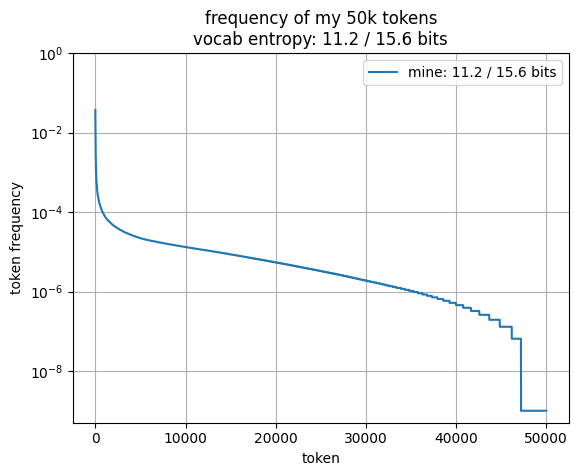

In [315]:
y_freqs_mine = np.array([v for t, v in freqs.most_common()])
#y_freqs = y_freqs[y_freqs != 0]
y_freqs_mine = y_freqs_mine / y_freqs_mine.sum()
y_freqs_mine = y_freqs_mine.clip(min=1e-9)
#y_freqs = sorted(y_freqs, reverse=True)
x_mine = range(len(y_freqs_mine))
plt.grid()

plt.plot(x_mine, y_freqs_mine, label=f"mine: {entropy(y_freqs_mine):.1f} / {np.log2(len(y_freqs_mine)):.1f} bits")
plt.ylim(5e-10, 1)
plt.yscale("log")
#plt.xscale("log")
plt.xlabel('token')
plt.ylabel('token frequency')
plt.title(f'frequency of my 50k tokens\nvocab entropy: {entropy(y_freqs_mine):.1f} / {np.log2(len(y_freqs_mine)):.1f} bits')
plt.legend()
plt.savefig('50k-token-frequencies.png', dpi=300)
plt.show()
plt.close()


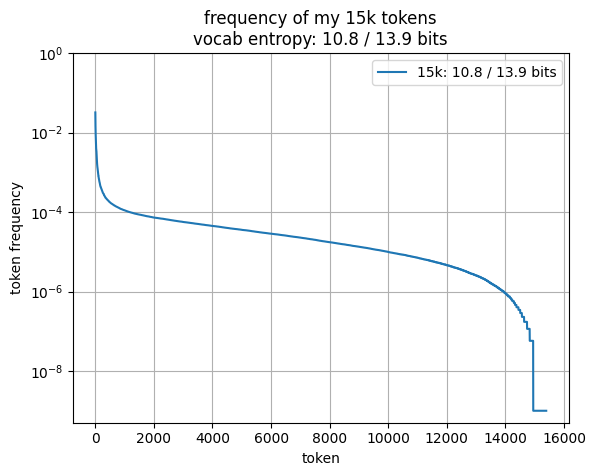

In [322]:
y_freqs_15k = np.array([v for t, v in freqs_15k.most_common()])
#y_freqs_15k = y_freqs_15k[y_freqs_15k != 0]
y_freqs_15k = y_freqs_15k / y_freqs_15k.sum()
y_freqs_15k = y_freqs_15k.clip(min=1e-9)
#y_freqs_15k = sorted(y_freqs_15k, reverse=True)
x_15k = range(len(y_freqs_15k))
plt.grid()

plt.plot(x_15k, y_freqs_15k, label=f"15k: {entropy(y_freqs_15k):.1f} / {np.log2(len(y_freqs_15k)):.1f} bits")
plt.ylim(5e-10, 1)
plt.yscale("log")
#plt.xscale("log")
plt.xlabel('token')
plt.ylabel('token frequency')
plt.title(f'frequency of my 15k tokens\nvocab entropy: {entropy(y_freqs_15k):.1f} / {np.log2(len(y_freqs_15k)):.1f} bits')
plt.legend()
plt.savefig('15k-token-frequencies.png', dpi=300)
plt.show()
plt.close()


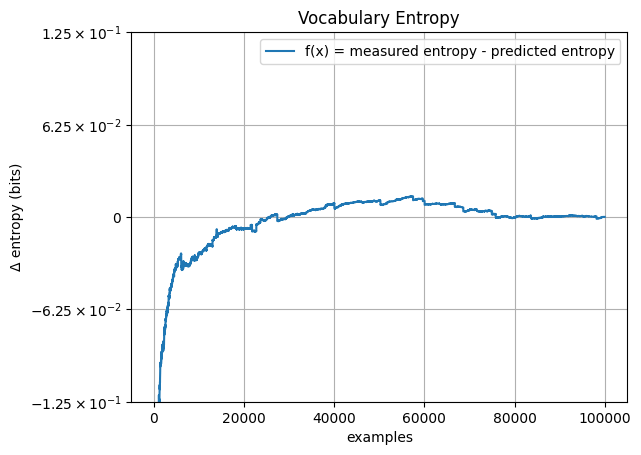

In [120]:
y = np.array(progress) - h
y = y[y != 0]
x = np.arange(len(y))
#plt.plot(x, np.abs(h - hs), label="abs(predicted - measured)")
plt.plot(x, y, label="f(x) = measured entropy - predicted entropy")
plt.yscale("symlog")
plt.xlabel("examples")
plt.ylabel("Δ entropy (bits)")
plt.title("Vocabulary Entropy")
plt.legend()
#bound = .025
bound = 1/8
plt.ylim(-bound, bound)
plt.yticks(np.arange(-bound, bound+ bound/4, bound/2))
plt.grid()
plt.show()

### compare with entropy of other vocabularies on the same data

### gpt2

In [290]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

gpt2_vocab_raw = tokenizer.get_vocab()
gpt2_max_token_size = max([len(t) for t in gpt2_vocab_raw])
gpt2_vocab = Vocabulary({bytes(t, 'utf-8'): 1 for t in gpt2_vocab_raw},
                        no_merge_on_right=[],
                        no_merge_on_left=[],
                        truncate_freq_lower_bound=0,
                        max_size=len(gpt2_vocab_raw),
                        max_token_len=gpt2_max_token_size)

h_gpt2, progress_gpt2, freqs_gpt2 = measure_vocab_entropy(gpt2_vocab, ds, 10_000)

print(f"Predicted vocabulary entropy: {gpt2_vocab.entropy(precision=3)} bits")
print(f"Measured vocabulary entropy: {h_gpt2:.3f} bits")


entropy (measured/predicted): 100%|##########| 15.617/15.617 [00:00<?, ?bit/s]

examples:   0%|          | 0/10000 [00:00<?, ?example/s]

Predicted vocabulary entropy: 15.617 bits
Measured vocabulary entropy: 7.660 bits


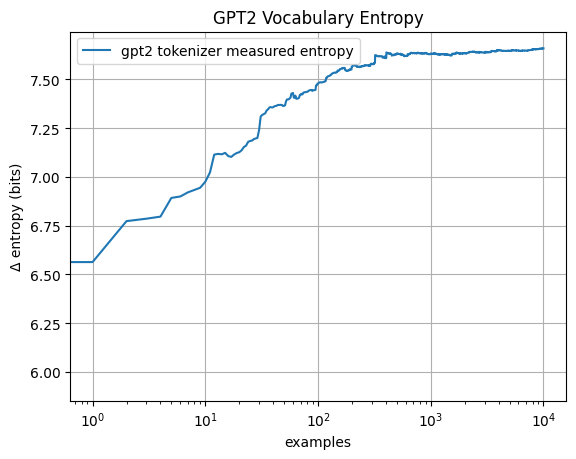

In [294]:

plt.close()
y = np.array(progress_gpt2)
y = y[y != 0]
x = np.arange(len(y))
#plt.plot(x, np.abs(h - hs), label="abs(predicted - measured)")
plt.plot(x, y, label="gpt2 tokenizer measured entropy")
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("examples")
plt.ylabel("Δ entropy (bits)")
plt.title("GPT2 Vocabulary Entropy")
plt.legend()
#bound = .025
#bound = 10
#plt.ylim(-bound, bound)
#plt.yticks(np.arange(-bound, bound+ bound/4, bound/2))
plt.grid()
plt.show()
plt.close()

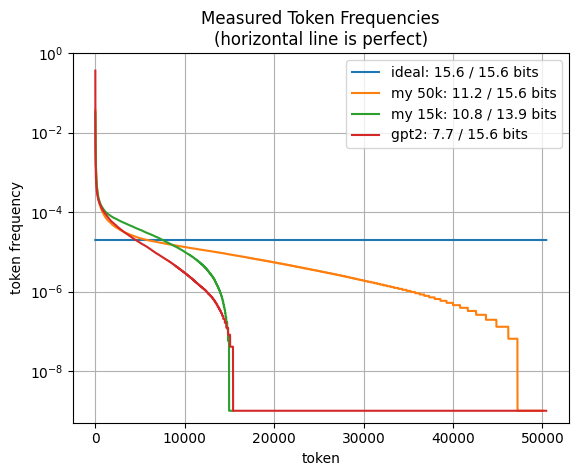

In [342]:
plt.close()
y_freqs_gpt2 = np.array([v for t, v in freqs_gpt2.most_common()])
#y_freqs = y_freqs[y_freqs != 0]
y_freqs_gpt2 = y_freqs_gpt2 / y_freqs_gpt2.sum()
y_freqs_gpt2 = y_freqs_gpt2.clip(min=1e-9)
#y_freqs = sorted(y_freqs, reverse=True)
x_gpt2 = range(len(y_freqs_gpt2))
plt.grid()
#plt.xscale("log")
plt.yscale("log")
plt.ylim(5e-10, 1)
#plt.ylim(0, 6e-5)

plt.plot(x_gpt2, np.ones(len(x_gpt2)) / len(x_gpt2), label=f"ideal: {np.log2(len(y_freqs_gpt2)):.1f} / {np.log2(len(y_freqs_gpt2)):.1f} bits")
plt.plot(x_mine, y_freqs_mine, label=f"my 50k: {entropy(y_freqs_mine):.1f} / {np.log2(len(y_freqs_mine)):.1f} bits")
plt.plot(x_15k, y_freqs_15k, label=f"my 15k: {entropy(y_freqs_15k):.1f} / {np.log2(len(y_freqs_15k)):.1f} bits")
plt.plot(x_gpt2, y_freqs_gpt2, label=f"gpt2: {entropy(y_freqs_gpt2):.1f} / {np.log2(len(y_freqs_gpt2)):.1f} bits")
plt.xlabel('token')
plt.ylabel('token frequency')
plt.title(f'Measured Token Frequencies\n(horizontal line is perfect)')
plt.legend()
plt.savefig('gpt2-token-frequencies.png', dpi=300)
plt.show()
plt.close()

In [319]:
max([len(t) for t, v in freqs_gpt2.most_common() if v > 0])

15

#### just individual bytes

In [230]:
bytes_vocab = Vocabulary(no_merge_on_right=[],
                        no_merge_on_left=[],
                        truncate_freq_lower_bound=0,
                        max_size=len(bytes_vocab_raw),
                        max_token_len=1)

h_bytes, progress_bytes, freqs_bytes = measure_vocab_entropy(bytes_vocab, ds, 10_000)

print(f"Predicted vocabulary entropy: {bytes_vocab.entropy(precision=3)} bits")
print(f"Measured vocabulary entropy: {h_bytes:.3f} bits")


entropy (measured/predicted): 100%|##########| 8.0/8.0 [00:00<?, ?bit/s]

examples:   0%|          | 0/10000 [00:00<?, ?example/s]

Predicted vocabulary entropy: 8.0 bits
Measured vocabulary entropy: 4.766 bits


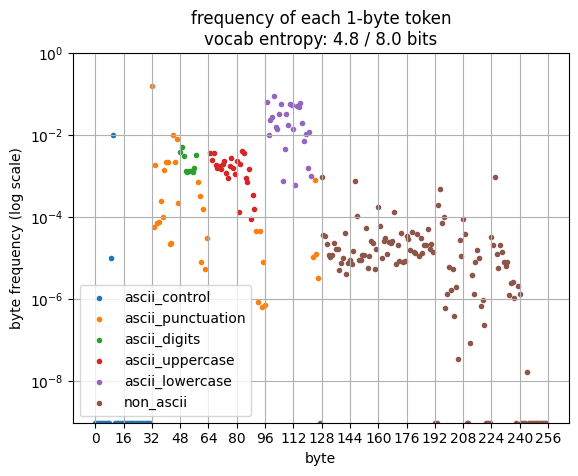

In [270]:
plt.close()
x = range(256)
y_freqs = np.array([freqs_bytes[bytes([i])] for i in x])
y_freqs = y_freqs / y_freqs.sum()
y_freqs = y_freqs.clip(min=1e-9)
colors = []
for i in x:
    if bytes([i]) in ASCII_LOWERCASE:
        colors.append("red")
    elif bytes([i]) in ASCII_UPPERCASE:
        colors.append("blue")
    elif bytes([i]) in ASCII_DIGITS:
        colors.append("green")
    elif bytes([i]) in ASCII_PUNCTUATION:
        colors.append("orange")
    elif bytes([i]) in ASCII_CONTROL:
        colors.append("black")
    elif bytes([i]) in NON_ASCII:
        colors.append("gray")

plt.xticks([i for i in range(0, 257, 16)])
plt.ylim(9.9e-10, 1)
plt.grid()

for label, tokens in [("ascii_control", ASCII_CONTROL), 
                        ("ascii_punctuation", ASCII_PUNCTUATION), 
                        ("ascii_digits", ASCII_DIGITS), 
                        ("ascii_uppercase", ASCII_UPPERCASE), 
                        ("ascii_lowercase", ASCII_LOWERCASE), 
                        ("non_ascii", NON_ASCII)]:
        x = [t[0] for t in tokens]
        y = [max(y_freqs[t[0]], 1e-9) for t in tokens]
        plt.scatter(x, y, marker='.', label=label)
plt.yscale("log")
plt.xlabel('byte')
plt.ylabel('byte frequency (log scale)')
plt.title(f'frequency of each 1-byte token\nvocab entropy: {entropy(list(freqs_bytes.values())):.1f} / {np.log2(256):.1f} bits')
plt.legend()
plt.savefig('1-byte-token-frequencies.png', dpi=300)
plt.show()
plt.close()


#### all 2-byte tokens


entropy (measured/predicted): 100%|##########| 16.002/16.002 [00:00<?, ?bit/s]

examples:   0%|          | 0/100000 [00:00<?, ?example/s]

Predicted vocabulary entropy: 16.002 bits
Measured vocabulary entropy: 8.552 bits


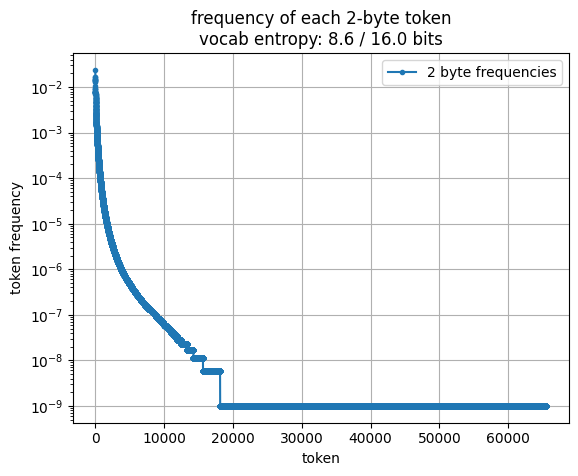

In [280]:
vocab_2bytes = Vocabulary([(bytes([i, j]), 1) for i in range(256) for j in range(256)],
                        no_merge_on_right=[],
                        no_merge_on_left=[],
                        truncate_freq_lower_bound=0,
                        max_size=256**2 + 256,
                        max_token_len=2)

h_2bytes, progress_2bytes, freqs_bytes = measure_vocab_entropy(vocab_2bytes, ds, 100_000)

print(f"Predicted vocabulary entropy: {vocab_2bytes.entropy(precision=3)} bits")
print(f"Measured vocabulary entropy: {h_2bytes:.3f} bits")



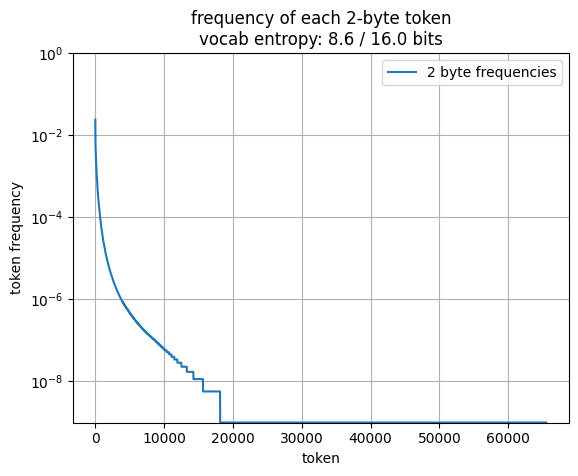

In [289]:
y_freqs = np.array([v for t, v in freqs_bytes.most_common() if len(t) == 2])
y_freqs = y_freqs / y_freqs.sum()
y_freqs = y_freqs.clip(min=1e-9)
#y_freqs = sorted(y_freqs, reverse=True)
x = range(len(y_freqs))
plt.grid()

plt.plot(x, y_freqs, label="2 byte frequencies")
plt.yscale("log")
#plt.xscale("log")
plt.ylim(9.9e-10, 1)
plt.xlabel('token')
plt.ylabel('token frequency')
plt.title(f'frequency of each 2-byte token\nvocab entropy: {entropy(y_freqs):.1f} / {np.log2(len(y_freqs)):.1f} bits')
plt.legend()
plt.savefig('2-byte-token-frequencies.png', dpi=300)
plt.show()
plt.close()



## animated video of token distributions during vocabulary training

In [163]:
# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
import matplotlib.animation as animation


class Animated(object):
    def __init__(self, time_stamps, token_freq_log, frame_rate, log_xscale=False, log_yscale=True, fixed_ylim=True, fixed_xlim=True, normalized=True):
        #if token_freq_log and (max(token_freq_log[0]) == 0):
        #    self.time_stamps, self.token_freq_log = time_stamps[1:], token_freq_log[1:]
        #else:
        self.time_stamps, self.token_freq_log = time_stamps, token_freq_log
        self.frame_rate = frame_rate
        self.log_xscale = log_xscale
        self.log_yscale = log_yscale
        self.fixed_xlim = fixed_xlim
        self.fixed_ylim = fixed_ylim
        self.normalized = normalized
        self.t0 = time_stamps[0]


        _, xs, ys = zip(*list(self.data_stream(progress=True, desc="finding x/y ranges", unit="frame", position=0, leave=False)))
        xs = sum([x.tolist() for x in xs], [])
        ys = sum([y.tolist() for y in ys], [])
        self.x_max = max(xs)
        self.x_min = min(xs)
        self.y_max = max(ys)
        self.y_min = min(ys)

        self.stream = self.data_stream(progress=True, desc="generating video", unit="frame")

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=200, 
                                          init_func=self.setup_plot, save_count=len(self.time_stamps), blit=True) # init_func=self.update, 

    def data_stream(self, progress=True, desc="reading data", unit="it", position=0, leave=True):
        d = list(zip(self.time_stamps, self.token_freq_log))
        #tqdm.write(f"{progress=}, {desc=}, {unit=}, {position=}, {leave=}")
        for raw_t, raw_freqs in tqdm(d, desc=desc, unit=unit, position=position, leave=leave):
            #if progress:
                #d.update(1)
                #d.refresh()
                #tqdm.write(f"{progress=}: updated progress")
            t = round(raw_t - self.t0)
            freqs = np.array(sorted(raw_freqs, reverse=True))
            if self.log_yscale:
                freqs = freqs.clip(.1)
            if self.normalized:
                freqs = freqs / freqs.sum()
            x = np.arange(1, len(freqs) + 1)
            yield t, x, freqs
        #tqdm.write(f"{progress=}: closing pb")
        #tqdm.write(f"{progress=} {desc=} done")

    def setup_plot(self):
        return self._render()

    def update(self, i=0):
        try:
            t, x, y = next(self.stream)
        except StopIteration:
            return []
        return self._render(t=t, x=x, y=y)

    def _render(self, t=None, y=None, x=None):
        for line in self.ax.lines:
            line.remove()

        if t is None:
            t = 0
        if y is None:
            y = sorted(token_freq_log[0], reverse=True)
        if x is None:
            x = np.arange(len(y))

        m = np.mean(y)

        plots = self.ax.plot(x, y, color="blue", label=f'token frequencies')
        plots += self.ax.plot(x, [m] * len(x), color="orange", label=f'mean = {m}')

        self.ax.set_title(f"{int(t):,}s since start" + \
                          f"\nentropy: {entropy(y):.01f} / {np.log2(len(y)):.01f} / {MAX_ENTROPY:.01f} bits" + \
                          f", {len(y)} tokens")
        #self.ax.set_xlabel('token id')
        self.ax.set_ylabel('num occurences')
        
        if self.log_yscale:
            self.ax.set_yscale('log')

        if self.log_xscale:
            self.ax.set_xscale('log')

        if self.fixed_xlim:
            self.ax.set_xlim(self.x_min, self.x_max)

        if self.fixed_ylim:
            self.ax.set_ylim(self.y_min, self.y_max)
        
        self.ax.legend()
        
        return plots

with np.errstate(invalid='ignore'):
    framerate = 30
    a = Animated(time_stamps, token_freq_log, framerate, log_xscale=False, log_yscale=True, fixed_ylim=False, fixed_xlim=False, normalized=True)
    #plt.show()
    a.ani.save('test.mp4', fps=framerate, extra_args=['-vcodec', 'libx264'])
    #a.ani.save('test.gif', fps=30)


finding x/y ranges:   0%|          | 0/2082 [00:00<?, ?frame/s]

/var/folders/xs/tqnvbbfn7dg26mmpnqp49fh80000gr/T/ipykernel_75584/793147815.py:88: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.ax.set_yscale('log')


generating video:   0%|          | 0/2082 [00:00<?, ?frame/s]